In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! echo $PYTHONPATH

/env/python


In [0]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Colab Notebooks/time-serie forecasting/"
! echo $PYTHONPATH

/env/python:/content/drive/My Drive/Colab Notebooks/time-serie forecasting/


**Import Libraries**

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random


import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/time-serie forecasting/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [0]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


let’s check out the data types of each column.

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


We start with converting `date_time` column to **datetime** and set it as an index

In [0]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [0]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [0]:
data.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object

Let's extract only 2 years data and create our time serie

In [0]:
data.index.min(), data.index.max()

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

In [0]:
ts = data['2016-09-30':'2018-09-29']

In [0]:
ts

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2016-09-30 00:00:00,None,284.26,0.0,0.0,0,Clear,Sky is Clear,2016-09-30 00:00:00,660
2016-09-30 01:00:00,None,283.99,0.0,0.0,0,Clear,Sky is Clear,2016-09-30 01:00:00,384
2016-09-30 02:00:00,None,283.17,0.0,0.0,0,Clear,Sky is Clear,2016-09-30 02:00:00,281
2016-09-30 03:00:00,None,282.43,0.0,0.0,0,Clear,Sky is Clear,2016-09-30 03:00:00,395
2016-09-30 04:00:00,None,282.87,0.0,0.0,0,Clear,Sky is Clear,2016-09-30 04:00:00,810
...,...,...,...,...,...,...,...,...,...
2018-09-29 19:00:00,None,280.68,0.0,0.0,90,Clouds,overcast clouds,2018-09-29 19:00:00,3818
2018-09-29 20:00:00,None,280.55,0.0,0.0,90,Clouds,overcast clouds,2018-09-29 20:00:00,3338
2018-09-29 21:00:00,None,280.40,0.0,0.0,90,Clouds,overcast clouds,2018-09-29 21:00:00,2950


Cheking missing values

In [0]:
ts.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [0]:
ts.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,21193.000000,21193.000000,21193.0,21193.000000,21193.000000
mean,281.267273,0.046567,0.0,48.146322,3271.748974
std,12.384096,0.390838,0.0,39.730445,1969.818720
min,243.390000,0.000000,0.0,0.000000,113.000000
25%,272.420000,0.000000,0.0,1.000000,1228.000000
50%,281.987000,0.000000,0.0,44.000000,3434.000000
75%,291.620000,0.000000,0.0,90.000000,4912.000000
max,310.070000,10.600000,0.0,100.000000,7280.000000


In [0]:
ts.describe(include='object')

,holiday,weather_main,weather_description
count,21193,21193,21193
unique,12,10,34
top,None,Clear,sky is clear
freq,21166,6222,5801


In [0]:
#Extracting features from date_time variable
ts['weekday'] = ts.date_time.dt.weekday_name
ts['hour'] = ts.date_time.dt.hour
ts['month'] = ts.date_time.dt.month
ts['year'] = ts.date_time.dt.year

# Univariate Analysis

In [0]:
# Using graph_objects
import plotly.graph_objects as go

layout = go.Layout(title='Traffic volume', xaxis=dict(title='Date'))
fig = go.Figure([go.Scatter(x=ts['date_time'], y=ts['traffic_volume'])], layout=layout)
fig.show()

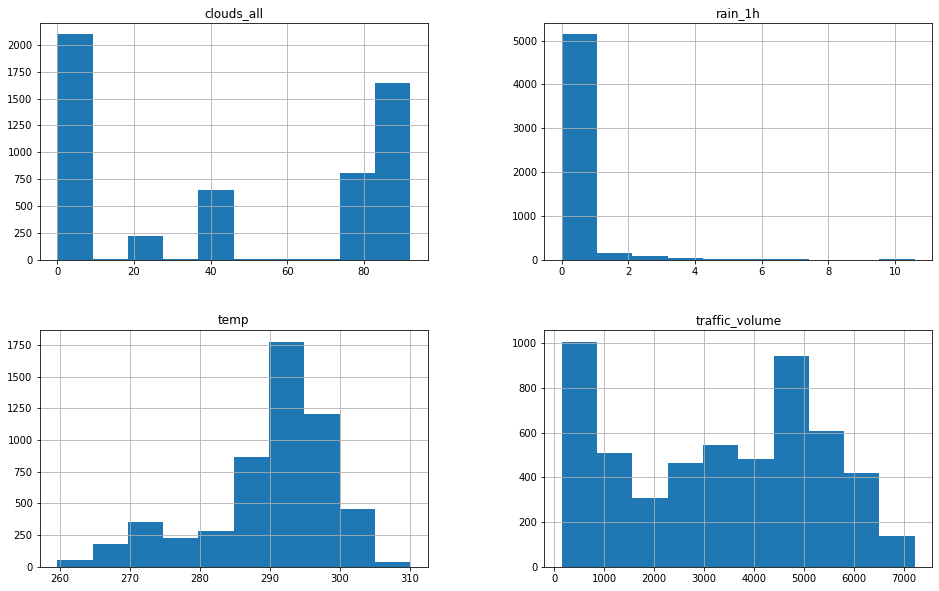

In [0]:
ts[['clouds_all','rain_1h','temp','traffic_volume']].hist(figsize=(16,10))
plt.show()

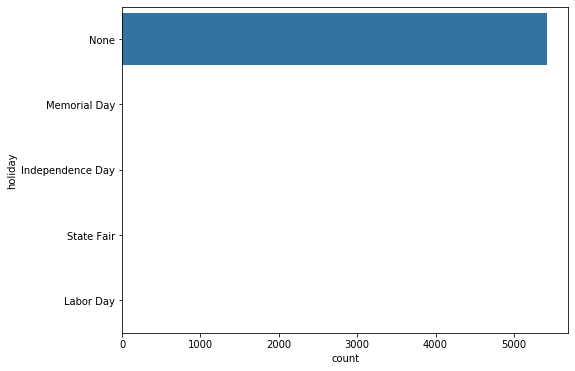

In [0]:
plt.figure(figsize = (8,6))
sns.countplot(y='holiday', data = ts)
plt.show()

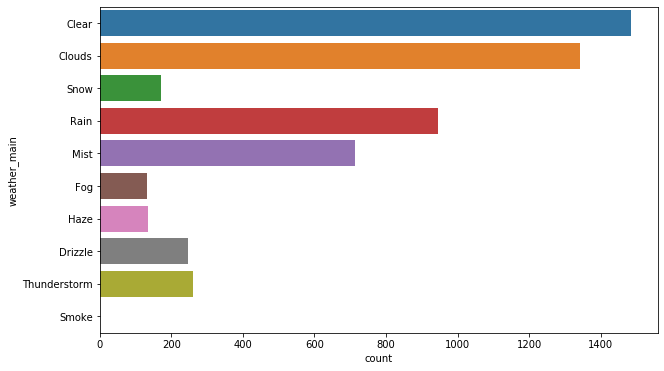

In [0]:
plt.figure(figsize = (10,6))
sns.countplot(y='weather_main', data = ts)
plt.show()

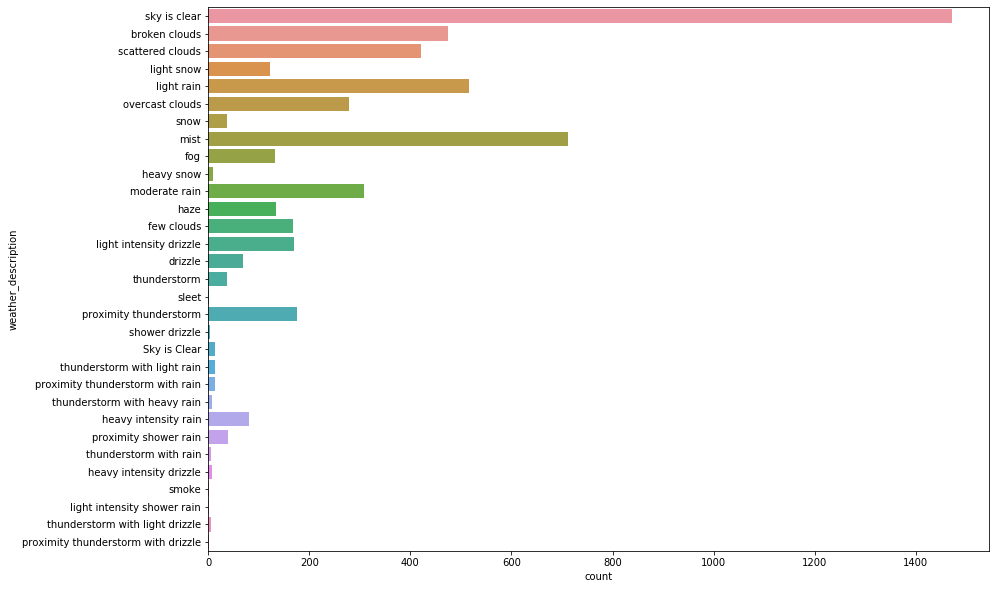

In [0]:
plt.figure(figsize = (14,10))
sns.countplot(y='weather_description', data = ts)
plt.show()

# Seasonality

let’s further explore the seasonality of our data with box plots

In [0]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(
                x=ts.date_time,
                y=ts['traffic_volume'],
                name="traffic volume",
                line_color='deepskyblue',
                opacity=0.8),
                secondary_y=False)

fig.add_trace(go.Scatter(
                x=ts.date_time,
                y=ts['temp'],
                name="temp",
                line_color='dimgray',
                opacity=0.8),
                secondary_y=True)

# Set x-axis title
fig.update_xaxes(title_text="Datetime")

# Set y-axes titles
fig.update_yaxes(title_text="<b>traffic volume</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>temperature</b>", secondary_y=True)

fig.show()

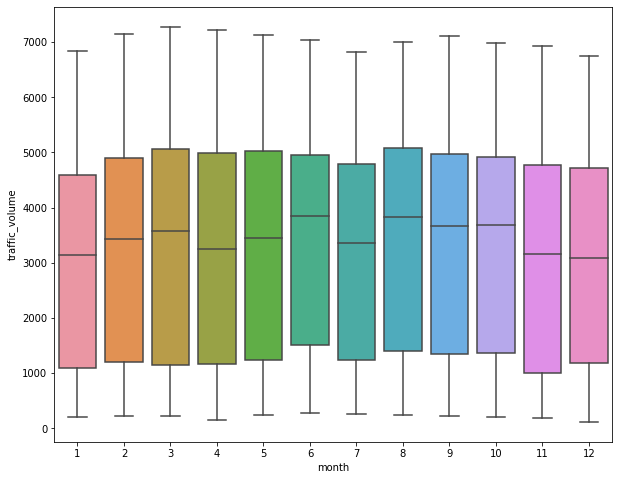

In [0]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='month', data = ts)
plt.show()

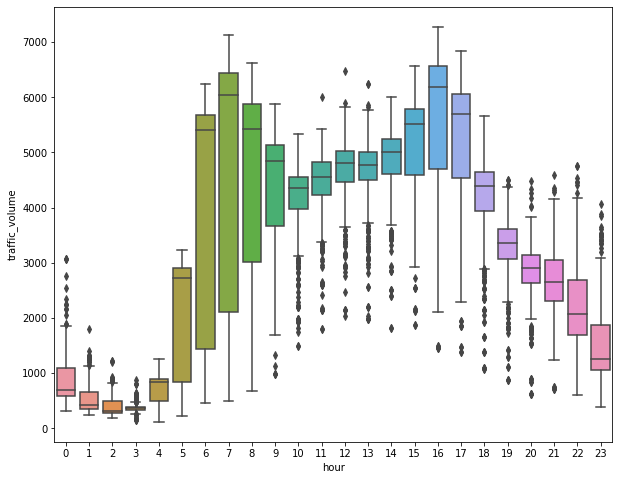

In [0]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='hour', data = ts)
plt.show()

This box plots confirm the daily seasonality
Traffic volumme is generally higher between 6am-9am and 3pm-5pm

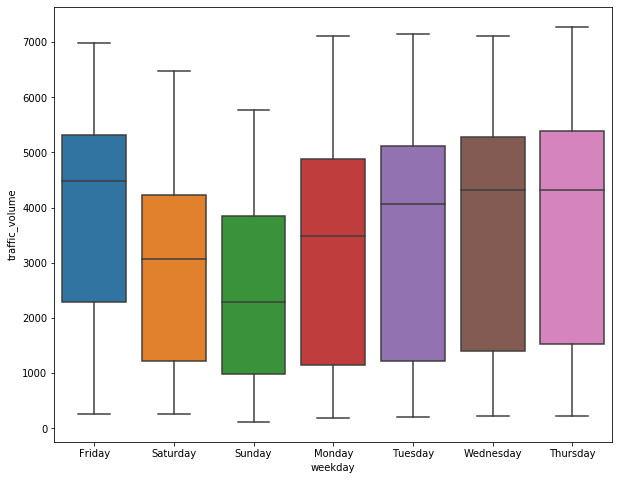

In [0]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='weekday', data = ts)
plt.show()

Traffic volumme is generally lower in the weekend

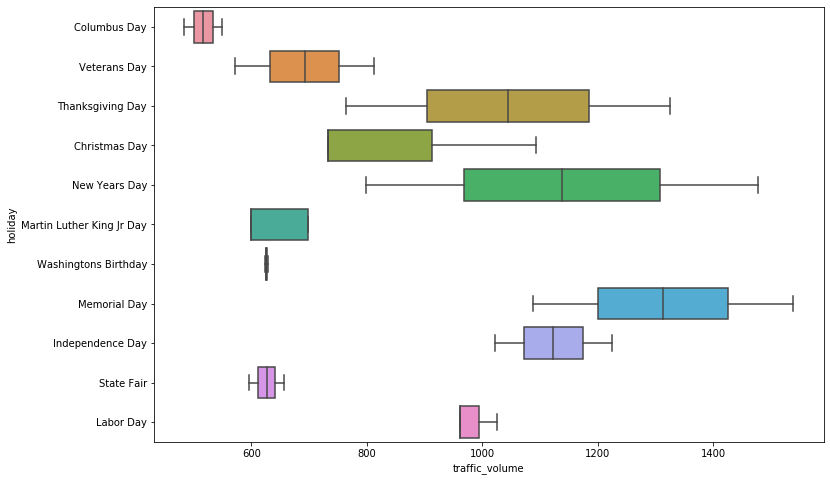

In [0]:
plt.figure(figsize=(12,8))
sns.boxplot(y='holiday',x='traffic_volume', data = ts.loc[ts.holiday != 'None'])
plt.show()

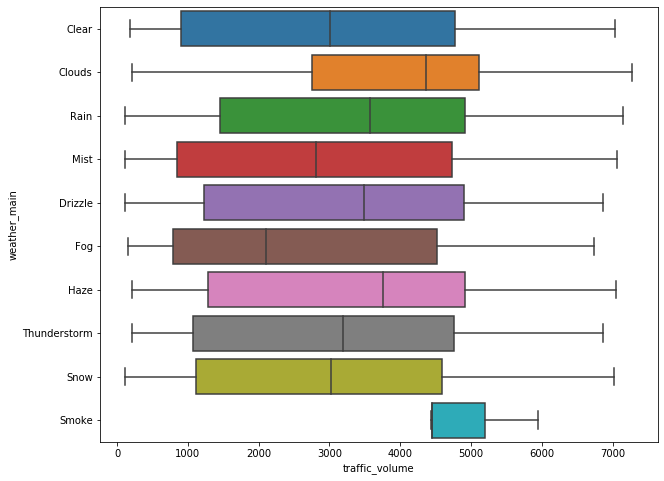

In [0]:
plt.figure(figsize=(10,8))
sns.boxplot(y='weather_main',x='traffic_volume', data = ts)
plt.show()

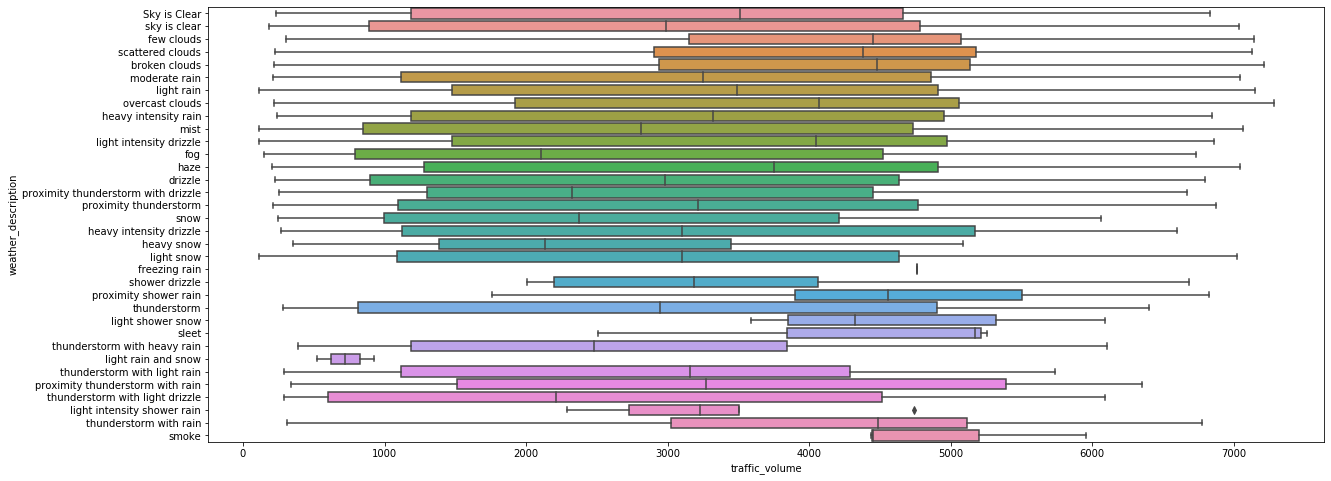

In [0]:
plt.figure(figsize=(20,8))
sns.boxplot(x='traffic_volume', y='weather_description', data = ts)
plt.show()

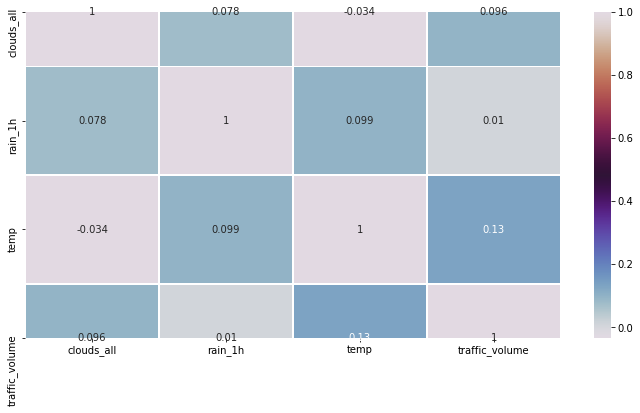

In [0]:
#correlation between different numeric variables. plot shows no strong correlation between traffic and other variables
cm = ts[['clouds_all','rain_1h','temp','traffic_volume']].corr()

plt.figure(figsize=(12,6))
sns.heatmap(cm,annot=True,linewidths=0.5,cmap='twilight')
plt.show()

There is no high correlation between traffic volume and other variables